In [2]:
import requests
import json

from shapely.ops import linemerge
from shapely.geometry import LineString, Polygon, MultiPolygon

from geopandas import GeoDataFrame
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

### Административные единицы

Данные о городе удобно агрегировать в границах административных единиц: районов и муницпальных образований.

In [5]:
def query_city_subdivisions(name, admin_level):
    """
        Query OSM overpass-api for realtionships, which 
        represent administrative entities within a city.
        see https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative 
        for info about admin_level
    """
    
    # see overpass query language
    overpass_query =f"""
    [out:json];
    area[name='{name}'];
    (rel[admin_level='{admin_level}'](area););
    out geom meta;
    """
    
    api_url = "http://overpass-api.de/api/interpreter"
    response = requests.get(api_url, params={'data': overpass_query})
    # print response status code
    print(response)
    data = response.json()
    return data

In [22]:
def json_to_gdf(data, tags=None):
    """
        Convert dictionary from OVERPASS response json to a GeoDataFrame.
        Works for closed contours like district boundaries etc.
    """
    districts = []
    # queried entities are stored in 'elements' item
    for element in tqdm(data['elements']):
        mline = []
        # the geometries (relationships) consists from 'members'
        # these are separate lines forming closed contours
        if element.get('members'):
            for member in element['members']:
                try:
                    mline.append(LineString([(m['lon'], m['lat']) for m in member['geometry']]))
                except KeyError:
                    pass
            mline = linemerge(mline)
        else:
            try:
                mline.append(LineString([(m['lon'], m['lat']) for m in element['geometry']]))
            except KeyError:
                pass
            mline = linemerge(mline)
        # some contours may be represented by MultiPolygons
        try:
            mline = Polygon(mline)
        except ValueError:
            pass
        except NotImplementedError:
            d = []
            for line in mline:
                d.append(Polygon(line))
            mline = MultiPolygon(d)
        if tags:
            items = [element['tags'].get(tag, 0) for tag in tags]
            districts.append((*items, mline))            
        else:
            districts.append((mline, ))
    if tags:
        gdf = GeoDataFrame(data=districts, columns=[*tags, 'geometry'], geometry='geometry', crs={'init': 'epsg:4326'})
    else:
        gdf = GeoDataFrame(data=districts, columns=['geometry', ], geometry='geometry', crs={'init': 'epsg:4326'})
    # OSM uses 'epsg:4326' (aka WGS84)
    
    return gdf

In [7]:
def plot_subdivision_map(gdf, annotate=False):
    """
        Plot the geodataframe (gdf), containing 'name' and 'geomnetry'.
    """
    if annotate:
        gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
        gdf['coords'] = [coords[0] for coords in gdf['coords']]
    fig, ax = plt.subplots(figsize=(30,20))
    gdf.plot(color='#fcba03', edgecolor='k', ax=ax)
    if annotate:
        for idx, row in gdf.iterrows():
            plt.annotate(s=row[annotate], xy=row['coords'], horizontalalignment='center', fontsize=8)
    plt.show()

100%|██████████| 18/18 [00:00<00:00, 270.40it/s]

<Response [200]>



/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


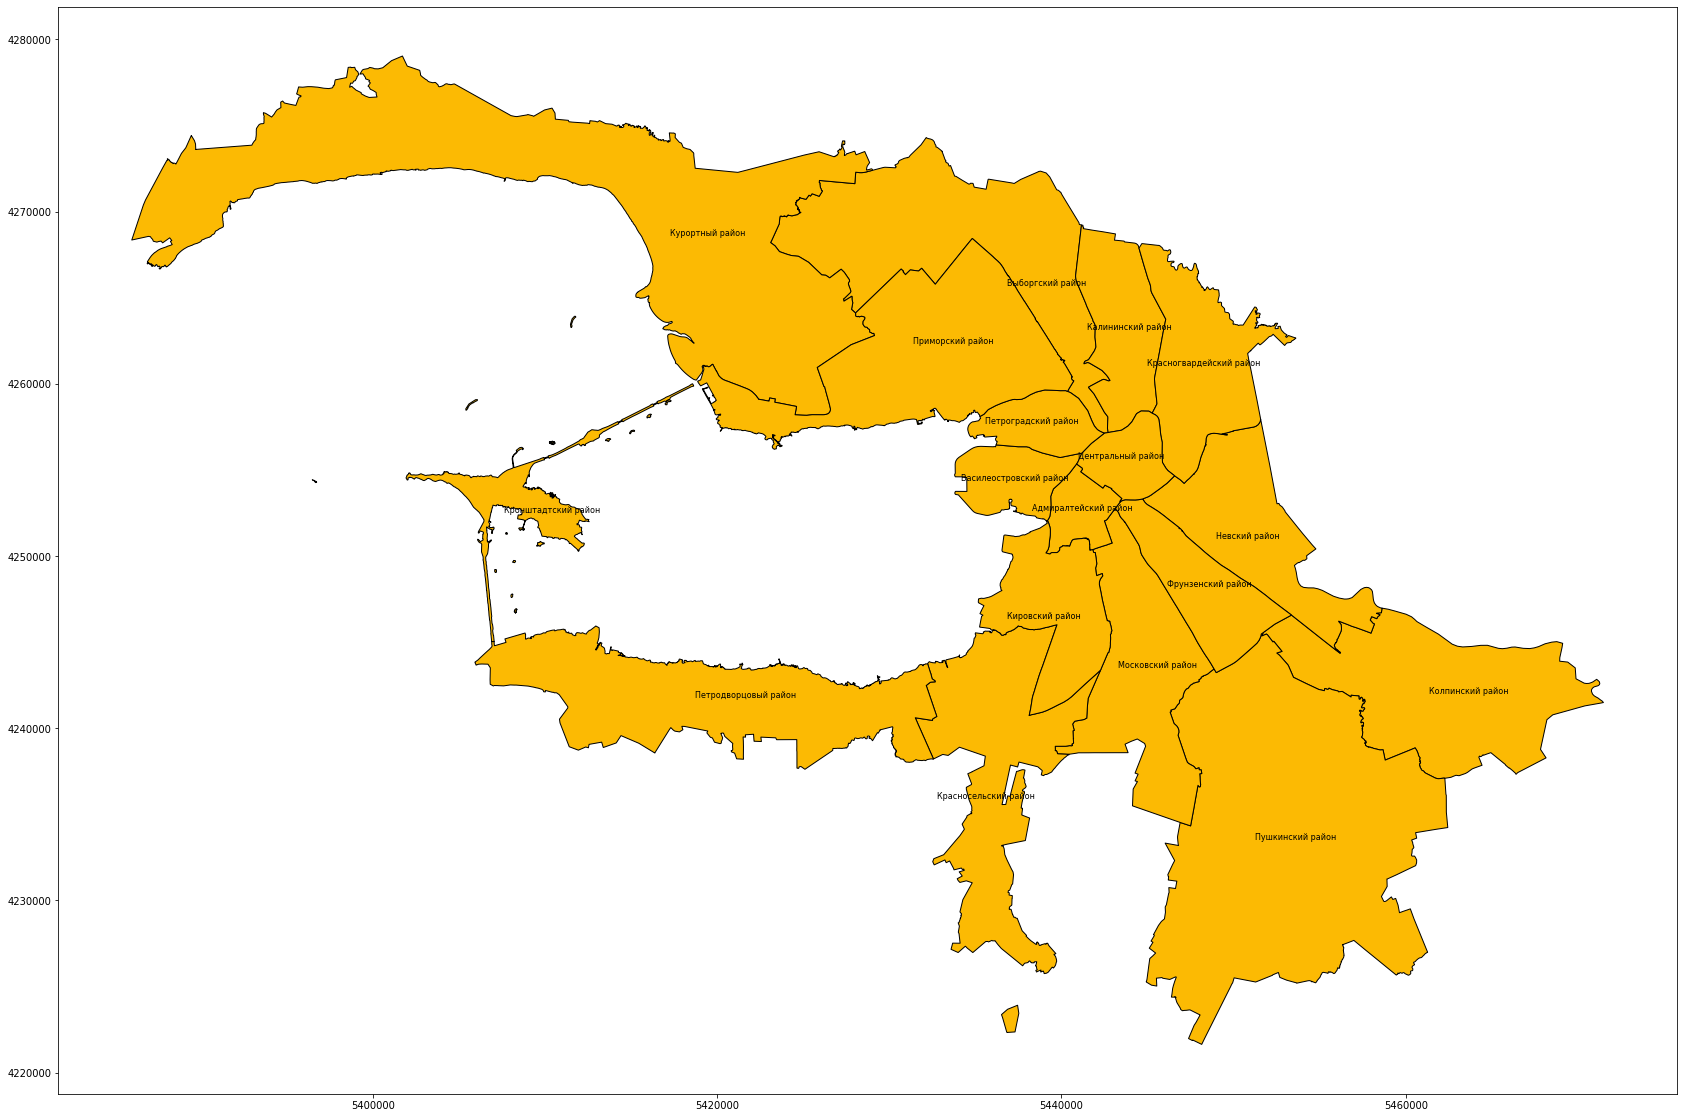

In [11]:
data_districts = query_city_subdivisions('Санкт-Петербург', 5)
gdf_districts = json_to_gdf(data_districts, ['name', ])
gdf_districts = gdf_districts.to_crs(epsg=3035)
plot_subdivision_map(gdf_districts, 'name')
# gdf_municip.to_file('shapes/districts/districts.shp')

 32%|███▏      | 36/111 [00:00<00:00, 356.55it/s]

<Response [200]>


100%|██████████| 111/111 [00:00<00:00, 346.23it/s]
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


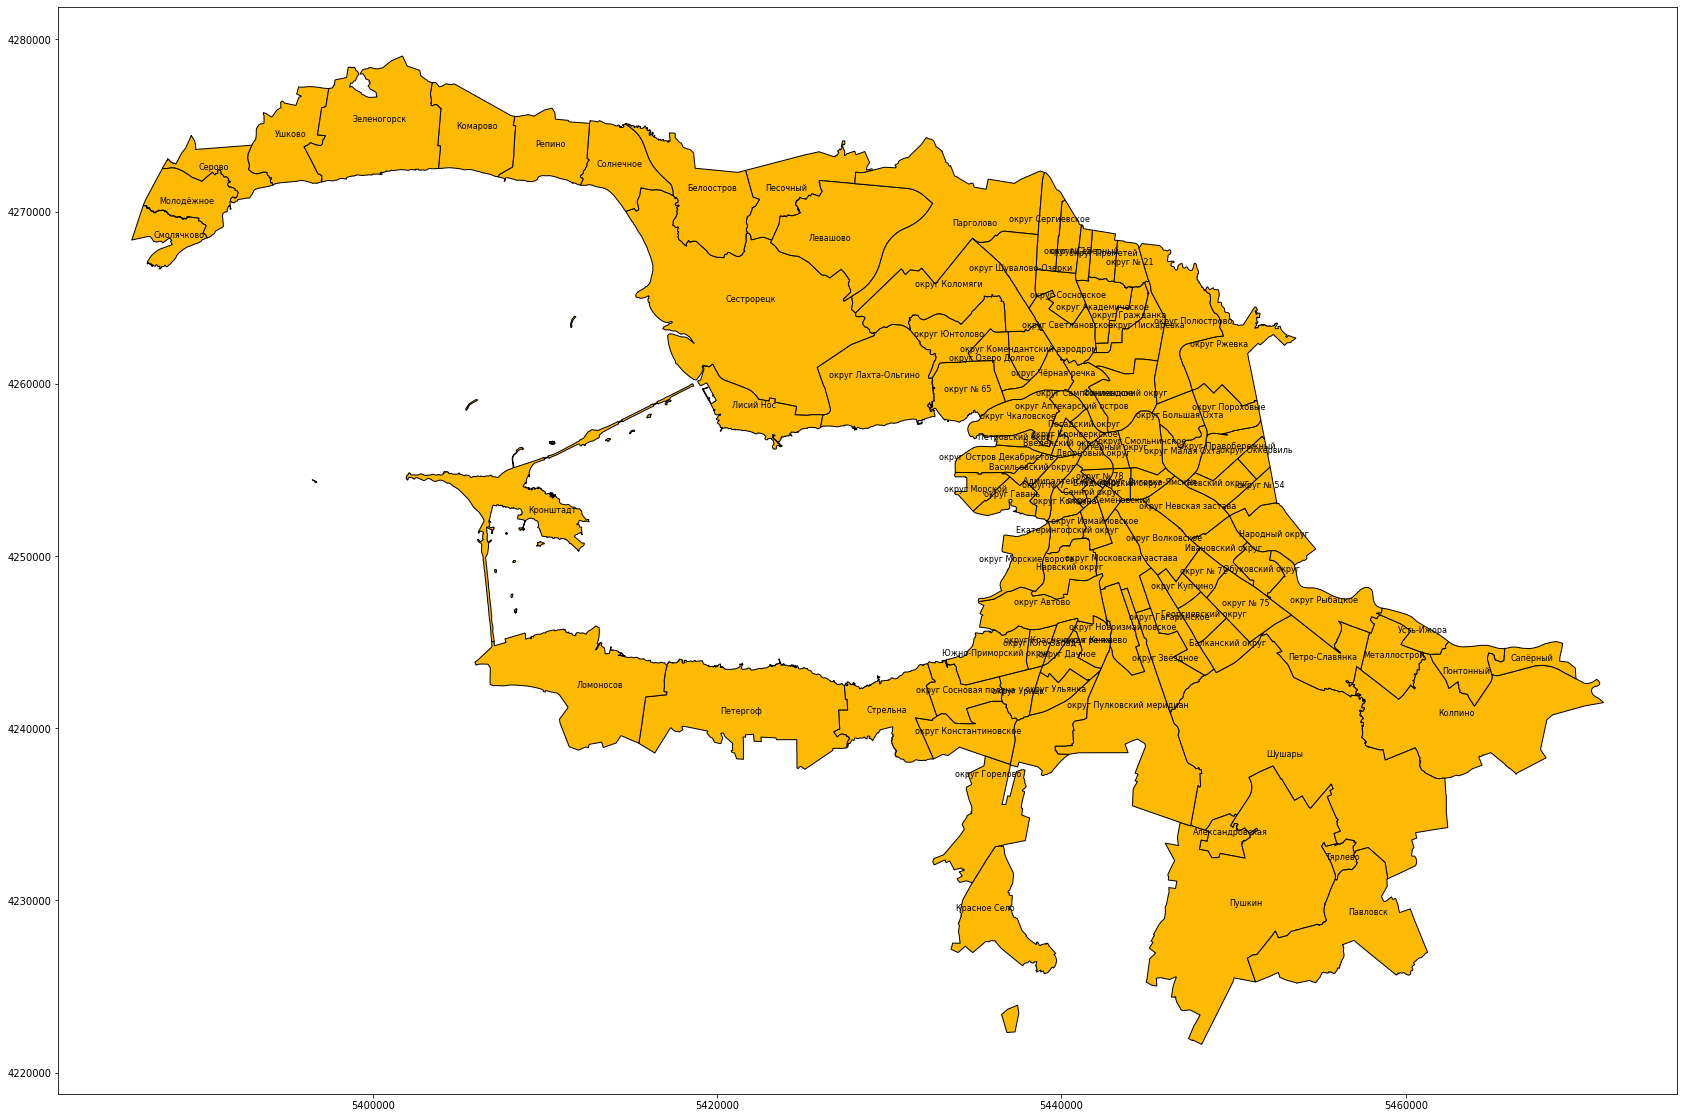

In [6]:
data_municip = query_city_subdivisions('Санкт-Петербург', 8)
gdf_municip = json_to_gdf(data_municip, ['name', ])
gdf_municip = gdf_municip.to_crs(epsg=3035)
plot_subdivision_map(gdf_municip, 'name')
# gdf_municip.to_file('shapes/municipalities/municipalities.shp')

### Buildings

In [28]:
overpass_query =f"""
    [out:json];
    area[name='Санкт-Петербург'];
    (way[building](area););
    out geom meta;
    """
    
api_url = "http://overpass-api.de/api/interpreter"
response = requests.get(api_url, params={'data': overpass_query})
print(response) # print response status code
data_buildings = response.json()
print(len(data_buildings['elements']))

<Response [200]>
137065


In [47]:
gdf_buildings = json_to_gdf(data_buildings, ['building', ])
gdf_buildings = gdf_buildings.to_crs(epsg=3035)
gdf_buildings.head()

100%|██████████| 137065/137065 [00:15<00:00, 8746.67it/s]
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,building,geometry
0,yes,"POLYGON ((5405459.951 4258482.908, 5405535.392..."
1,store,"POLYGON ((5444580.578 4266964.742, 5444594.225..."
2,yes,"POLYGON ((5435119.408 4258715.703, 5435120.630..."
3,yes,"POLYGON ((5444676.778 4266538.896, 5444658.567..."
4,school,"POLYGON ((5442162.470 4267686.670, 5442132.554..."


In [41]:
city = gpd.read_file('shapes/districts/districts.shp', encoding='utf-8').to_crs(epsg=3035)
bbox = city.unary_union.bounds
bbox = shapely.geometry.box(*bbox)

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [50]:
gdf_buildings2 = gpd.sjoin(gdf_buildings, gpd.GeoDataFrame([bbox,], columns=['geometry',], geometry='geometry'), op='within')

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:3035', 'no_defs': True} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [51]:
gdf_buildings2

,building,geometry,index_right
0,yes,"POLYGON ((5405459.951 4258482.908, 5405535.392...",0
1,store,"POLYGON ((5444580.578 4266964.742, 5444594.225...",0
2,yes,"POLYGON ((5435119.408 4258715.703, 5435120.630...",0
3,yes,"POLYGON ((5444676.778 4266538.896, 5444658.567...",0
4,school,"POLYGON ((5442162.470 4267686.670, 5442132.554...",0
...,...,...,...
137060,service,"POLYGON ((5445826.549 4259470.240, 5445831.234...",0
137061,service,"POLYGON ((5445743.589 4258746.660, 5445745.097...",0
137062,yes,"POLYGON ((5446534.428 4257916.481, 5446547.548...",0
137063,yes,"POLYGON ((5446546.468 4257783.120, 5446583.043...",0


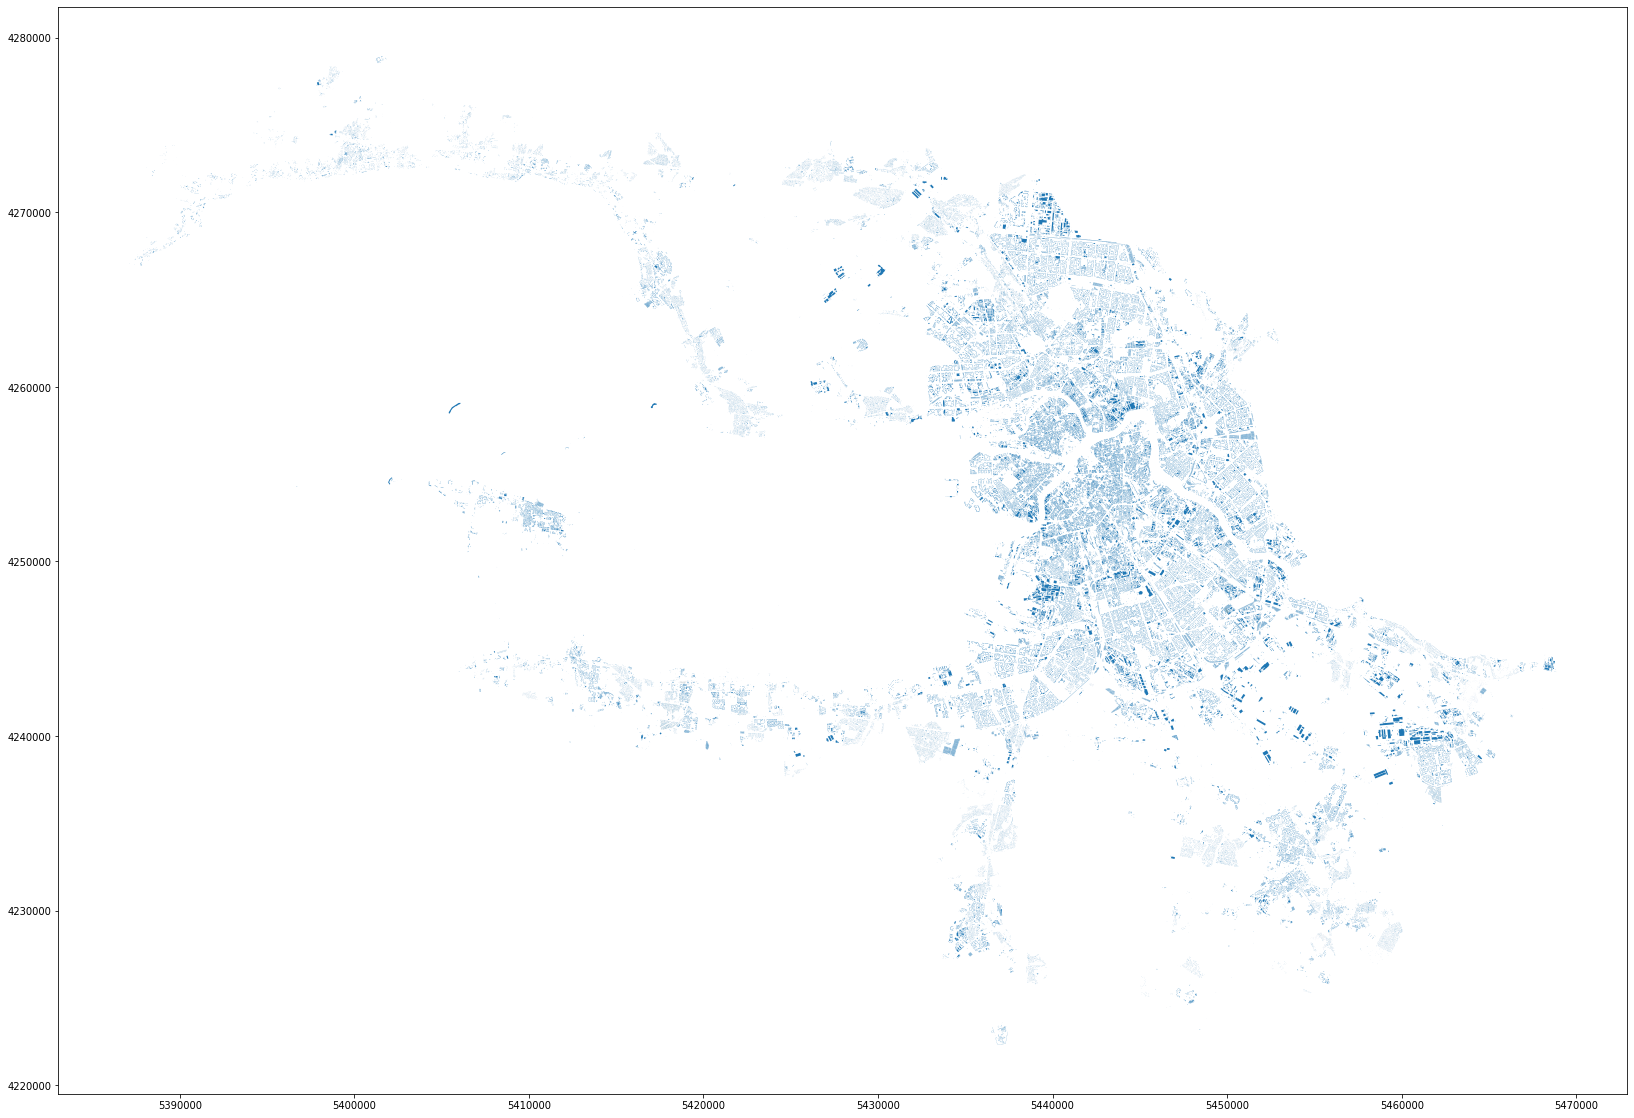

In [52]:
fig, ax = plt.subplots(figsize=(30,20))
gdf_buildings2.plot(ax=ax)

In [53]:
gdf_buildings.to_file('shapes/buildings_new/buildings_new.shp', encoding='utf-8')

### Landuse

In [3]:
overpass_query =f"""
    [out:json];
    area[name='Санкт-Петербург'];
    (way[landuse](area););
    out geom meta;
    """

api_url = "http://overpass-api.de/api/interpreter"
response = requests.get(api_url, params={'data': overpass_query})
print(response) # print response status code
data_landuse = response.json()
print(len(data_landuse['elements']))

<Response [200]>
16193


NameError: name 'gdf_landuse' is not defined

100%|██████████| 16193/16193 [00:01<00:00, 8351.69it/s]


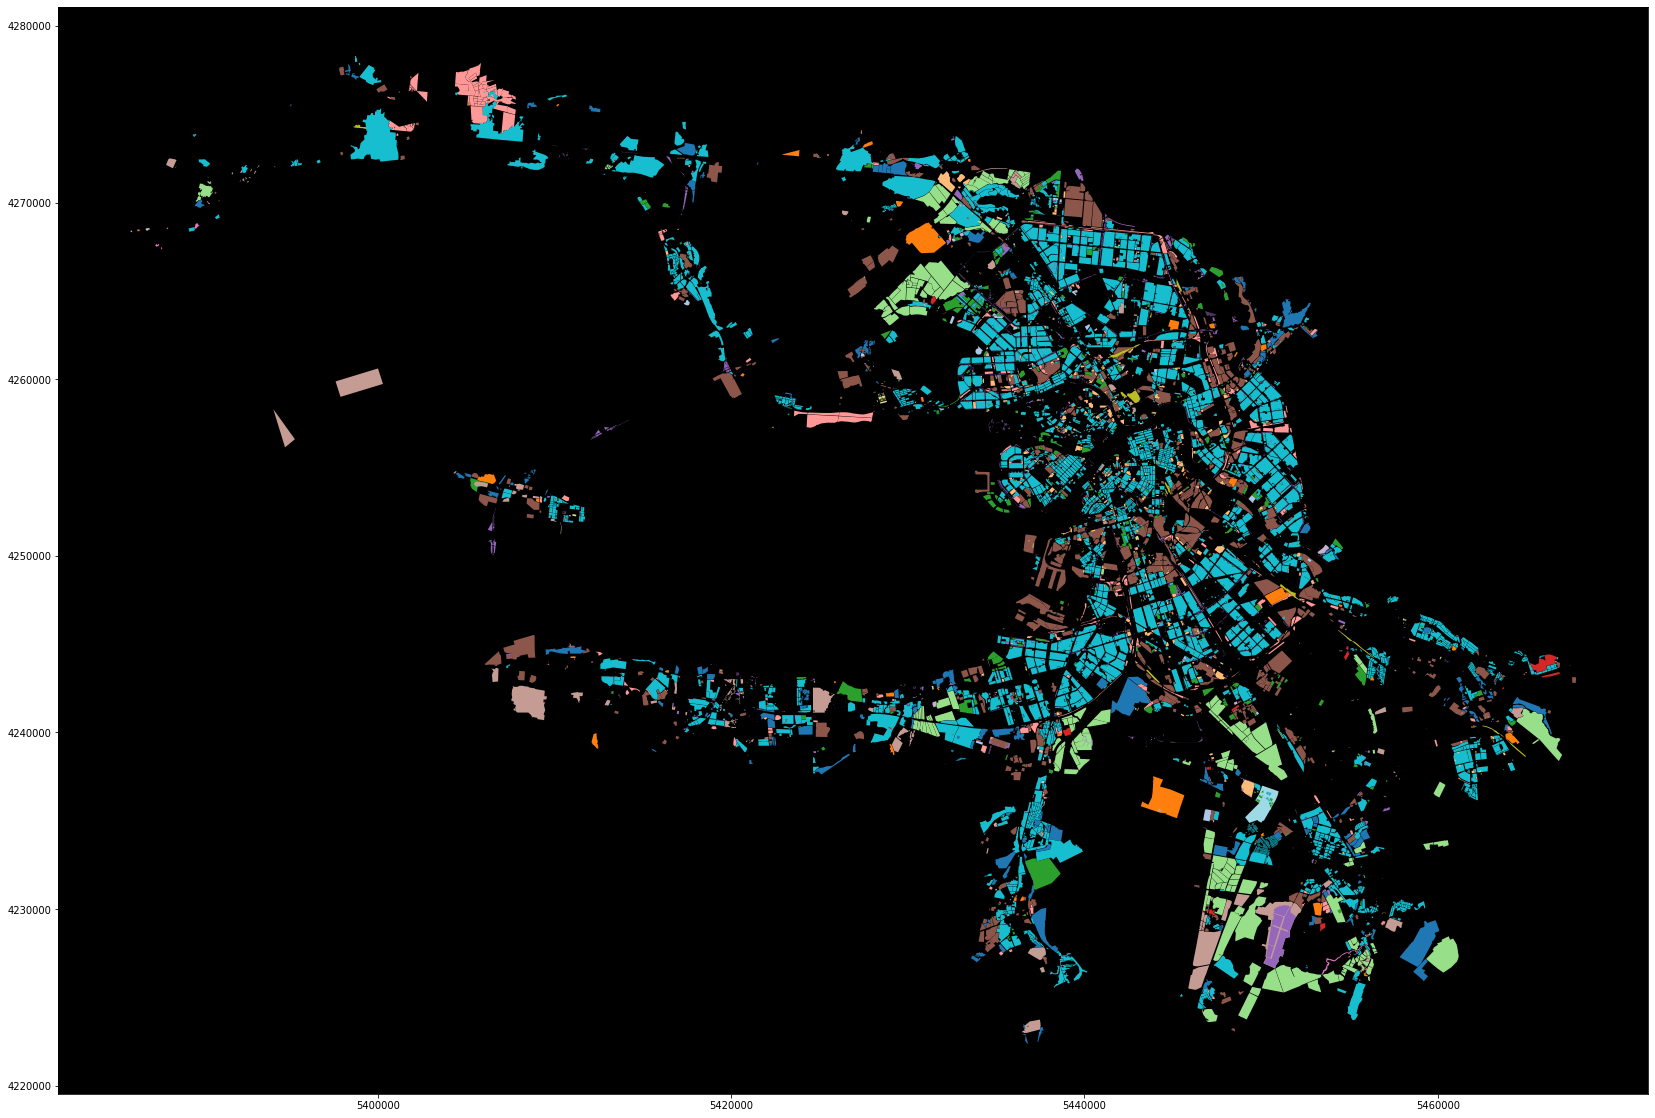

In [20]:
gdf_landuse = json_to_gdf(data_landuse, ['landuse', ])
fig, ax = plt.subplots(figsize=(30,20))
ax.set_facecolor('k')
gdf_landuse.to_crs(epsg=3035).plot(column='landuse', cmap='tab20', ax=ax)

In [27]:
gdf_landuse.to_csv('shapes/landuse.csv')

### Grid

Для более мелкомасштабной аггрегации данных, к тому же непривязанной к границам административных единиц, построим квадратную сетку по размерам карты города.

In [3]:
def shape_mesh(bbox, size):
    l, b, r, t = bbox
    sm = shapely.geometry.box(l, b, r, t)
    x = np.arange(l, r, size)
    y = np.arange(b, t, size)
    squares = []
    for j in range(len(y) - 1):
        for i in range(len(x) - 1):
            square = shapely.geometry.box(x[i], y[j], x[i+1], y[j+1])
            squares.append(square)
    return squares

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


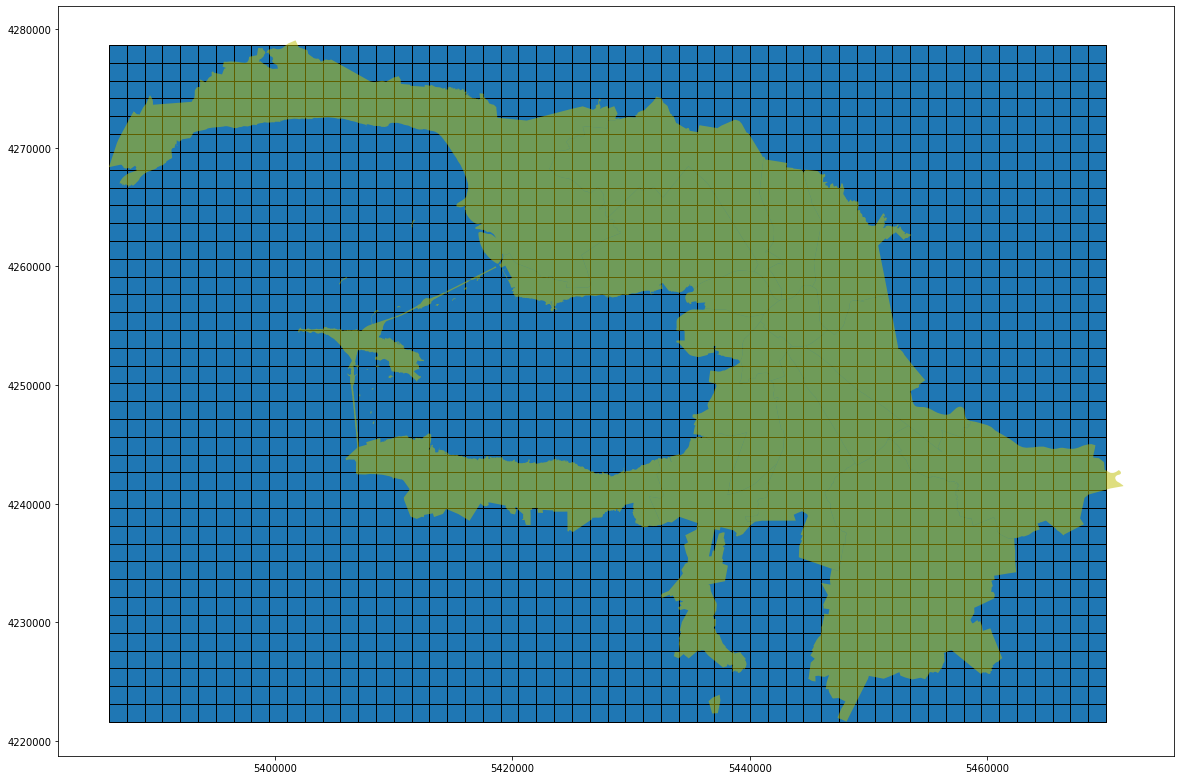

In [9]:
size = 1500

city = gpd.read_file('shapes/districts/districts.shp', encoding='utf-8').to_crs(epsg=3035)
sqrs = shape_mesh(city.unary_union.bounds, size)
sqrs = gpd.GeoDataFrame(sqrs, columns=['geometry', ], geometry='geometry', crs={'init': 'epsg:3035'})

fid, ax = plt.subplots(figsize=(20, 30))
sqrs.plot(ax=ax, edgecolor='k')
city.plot(ax=ax, alpha=0.5, color='y')

In [10]:
sqrs.to_file(f'shapes/grid{size}/grid{size}.shp', encoding='utf-8')